In [1]:
import cv2 as cv
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import keras

In [2]:
tf.__version__

'2.15.0'

In [3]:
keras.__version__

'2.15.0'

In [4]:
# Initialize the face detector with an ONNX model (YuNet model for face detection)
# Parameters: model file, empty string (optional), input size (320x320), confidence threshold (0.8), 
# non-maximum suppression threshold (0.3), and maximum number of faces to detect (5000)
detector = cv.FaceDetectorYN.create("face_detection_yunet_2023mar.onnx", "", (320, 320), 0.8, 0.3, 5000)

# Load the pre-trained emotion classification model
emotion_classification_model = tf.keras.models.load_model('emotion_classification.h5')

# Load the pre-trained gender classification model
gender_classification_model = tf.keras.models.load_model('gender_classification.h5' , compile=False)

# Define the list of emotion labels corresponding to the emotion classification model output
lables_list = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Function to interpret gender classification result
# If the result is less than 0.8, return 'female', otherwise return 'male'
def F_or_M(x):
    return 'female' if x < 0.6 else 'male'


In [5]:
def predict(faces , image):
    if faces[1] is not None:
        faces_detected = []
        for face in faces[1]:
            face_emotion = image[int(face[1]) - 20 :int(face[1]) + int(face[3])  + 20, int(face[0]) -20 :int(face[0]) + int(face[2]) + 20, :]
            face_gender = image[int(face[1]) - 30:int(face[1]) + int(face[3]) + 30 , int(face[0]) - 30:int(face[0]) + int(face[2]) + 30, :]
            color = (255,100,255)
            faces_detected.append(face_emotion)
            
            
            face_gender = cv.cvtColor(face_gender , cv.COLOR_BGR2RGB)
            face_emotion = cv.cvtColor(face_emotion , cv.COLOR_BGR2RGB)
            
            if face_emotion is not None:
                face_emotion = cv.resize(face_emotion , dsize=(224,224))
                face_emotion = tf.cast(face_emotion , tf.float32) / 255.0
                face_emotion = tf.expand_dims(face_emotion , axis=0)
                result_emotion = emotion_classification_model.predict(face_emotion , verbose=0)
                result_emotion = lables_list[tf.argmax(result_emotion[0])]
                cv.putText(image , result_emotion , (int(face[0]) , int(face[1]) + int(face[3] + 20)) , cv.FONT_HERSHEY_PLAIN , 1 , (0 , 0 , 255) , 1)

            if face_gender is not None:
                face_gender = cv.resize(face_gender , dsize=(224,224))
                face_gender = tf.cast(face_gender , tf.float32) / 255.0
                face_gender = tf.expand_dims(face_gender , axis=0)
                result_gender = F_or_M(gender_classification_model.predict(face_gender , verbose=0))
                if result_gender == 'male':
                    color = (255,0,0)
                cv.putText(image , result_gender , (int(face[0] + int(face[2])) , int(face[1]) + int(face[3] + 20)) , cv.FONT_HERSHEY_PLAIN , 1 , color , 1)
                cv.rectangle(image , (int(face[0]) , int(face[1])) , (int(face[0]) + int(face[2]) , int(face[1]) + int(face[3])) , color , 1)
    return faces_detected

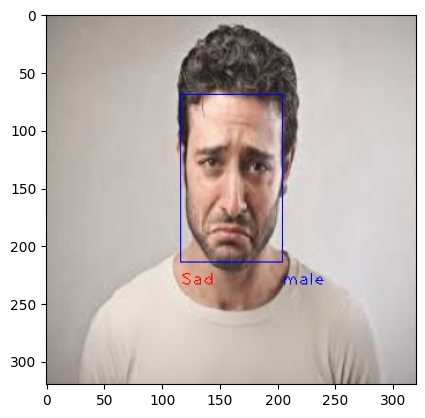

In [6]:
image = cv.imread('sadman.jpeg')
image = cv.resize(image , dsize=(320,320))
faces = detector.detect(image)

predict(faces , image)

plt.imshow(image[...,::-1])


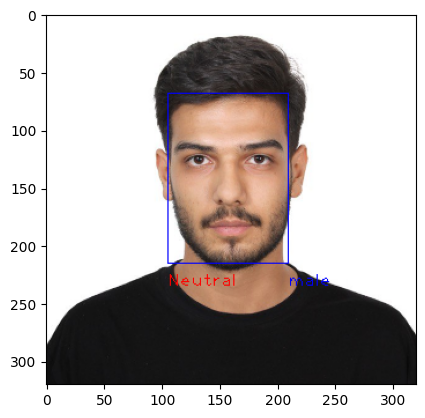

In [7]:
image = cv.imread('matin.jpg')
image = cv.resize(image , dsize=(320,320))
faces = detector.detect(image)

faces_detected = predict(faces , image)

plt.imshow(image[...,::-1])


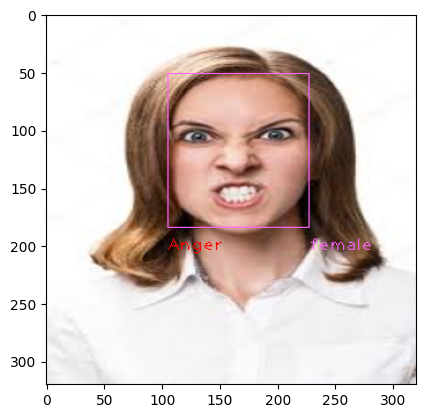

In [8]:
image = cv.imread('angrywoman.jpeg')
image = cv.resize(image , dsize=(320,320))
faces = detector.detect(image)

faces_detected = predict(faces , image)

plt.imshow(image[...,::-1])


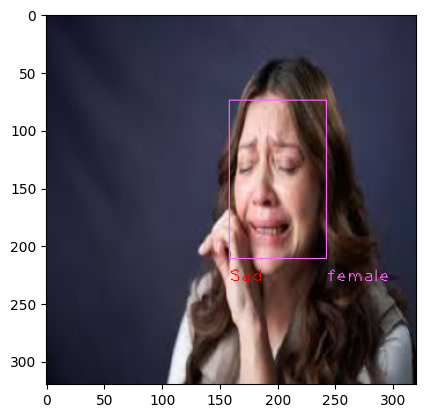

In [9]:
image = cv.imread('sadwoman.jpeg')
image = cv.resize(image , dsize=(320,320))
faces = detector.detect(image)

faces_detected = predict(faces , image)

plt.imshow(image[...,::-1])


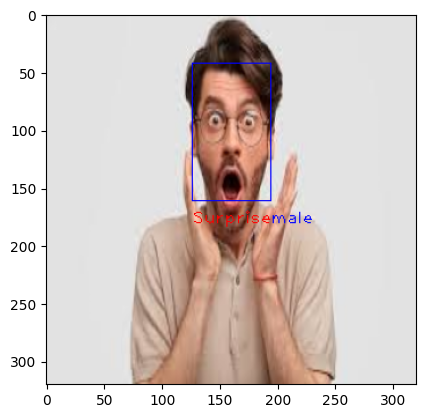

In [10]:
image = cv.imread('suprised_man.jpeg')
image = cv.resize(image , dsize=(320,320))
faces = detector.detect(image)

faces_detected = predict(faces , image)

plt.imshow(image[...,::-1])


In [ ]:
webcam = cv.VideoCapture(0)
width = int(webcam.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(webcam.get(cv.CAP_PROP_FRAME_HEIGHT))
detector.setInputSize((width , height))
lables_list = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
while True:
    ok , frame = webcam.read()
    if not ok:
        break
    frame = cv.flip(frame , 1)
    faces = detector.detect(frame)

    if faces[1] is not None:
        for face in faces[1]:
            x, y, w, h = int(face[0]), int(face[1]), int(face[2]), int(face[3])
            
            x1, y1 = max(0, x - 30), max(0, y - 30)
            x2, y2 = min(width, x + w + 30), min(height, y + h + 30)
            x1_gender, y1_gender = max(0, x - 30), max(0, y - 30)
            x2_gender, y2_gender = min(width, x + w + 30), min(height, y + h + 30)
            
            face_emotion = frame[y1:y2, x1:x2, :]
            face_gender = frame[y1_gender:y2_gender, x1_gender:x2_gender, :]
            color = (255,100,255)

            
            face_gender = cv.cvtColor(face_gender , cv.COLOR_BGR2RGB)
            face_emotion = cv.cvtColor(face_emotion , cv.COLOR_BGR2RGB)
            
            if face_emotion is not None:
                face_emotion = cv.resize(face_emotion , dsize=(224,224))
                face_emotion = tf.cast(face_emotion , tf.float32) / 255.0
                face_emotion = tf.expand_dims(face_emotion , axis=0)
                result_emotion = emotion_classification_model.predict(face_emotion , verbose=0)
                result_emotion = lables_list[tf.argmax(result_emotion[0])]
                cv.putText(frame , result_emotion , (int(face[0]) , int(face[1]) + int(face[3] + 20)) , cv.FONT_HERSHEY_PLAIN , 1 , (0 , 0 , 255) , 1)

            if face_gender is not None:
                face_gender = cv.resize(face_gender , dsize=(224,224))
                face_gender = tf.cast(face_gender , tf.float32) / 255.0
                face_gender = tf.expand_dims(face_gender , axis=0)
                result_gender_predict = gender_classification_model.predict(face_gender , verbose=0)
                result_gender_final = F_or_M(result_gender_predict)
                if result_gender_final == 'male':
                    color = (255,0,0)
                cv.putText(frame , result_gender_final , (int(face[0] + int(face[2])) , int(face[1]) + int(face[3] + 20)) , cv.FONT_HERSHEY_PLAIN , 1 , color , 1)
                cv.rectangle(frame , (int(face[0]) , int(face[1])) , (int(face[0]) + int(face[2]) , int(face[1]) + int(face[3])) , color , 1)
    cv.imshow('frame' , frame)
    if cv.waitKey(1) & 0xff == ord('q'):
        break

webcam.release()
cv.destroyAllWindows()